# Increase in Grover's Algorithm complexity due to Isotropic Error

In [1]:
from isotropic.algos.grover import get_grover_circuit
from isotropic.utils.state_transforms import generate_and_add_isotropic_error
from joblib import Parallel, delayed
from qiskit.quantum_info import Operator, Statevector

import jax.numpy as jnp
import matplotlib.pyplot as plt

## Oracle

We first implement the oracle that will add a phase to our desired search item ($00011$). 

**Note the negative sign on one of the diagonal entries.**

In [2]:
oracle = jnp.eye(2**5).tolist()
oracle[3][3] = -1
U_w = Operator(oracle)

In [3]:
num_qubits = 5

## Grover's Circuit

We can now build the circuit and visualise it

In [4]:
grover_circuit = get_grover_circuit(num_qubits=num_qubits, U_w=U_w, iterations=3)

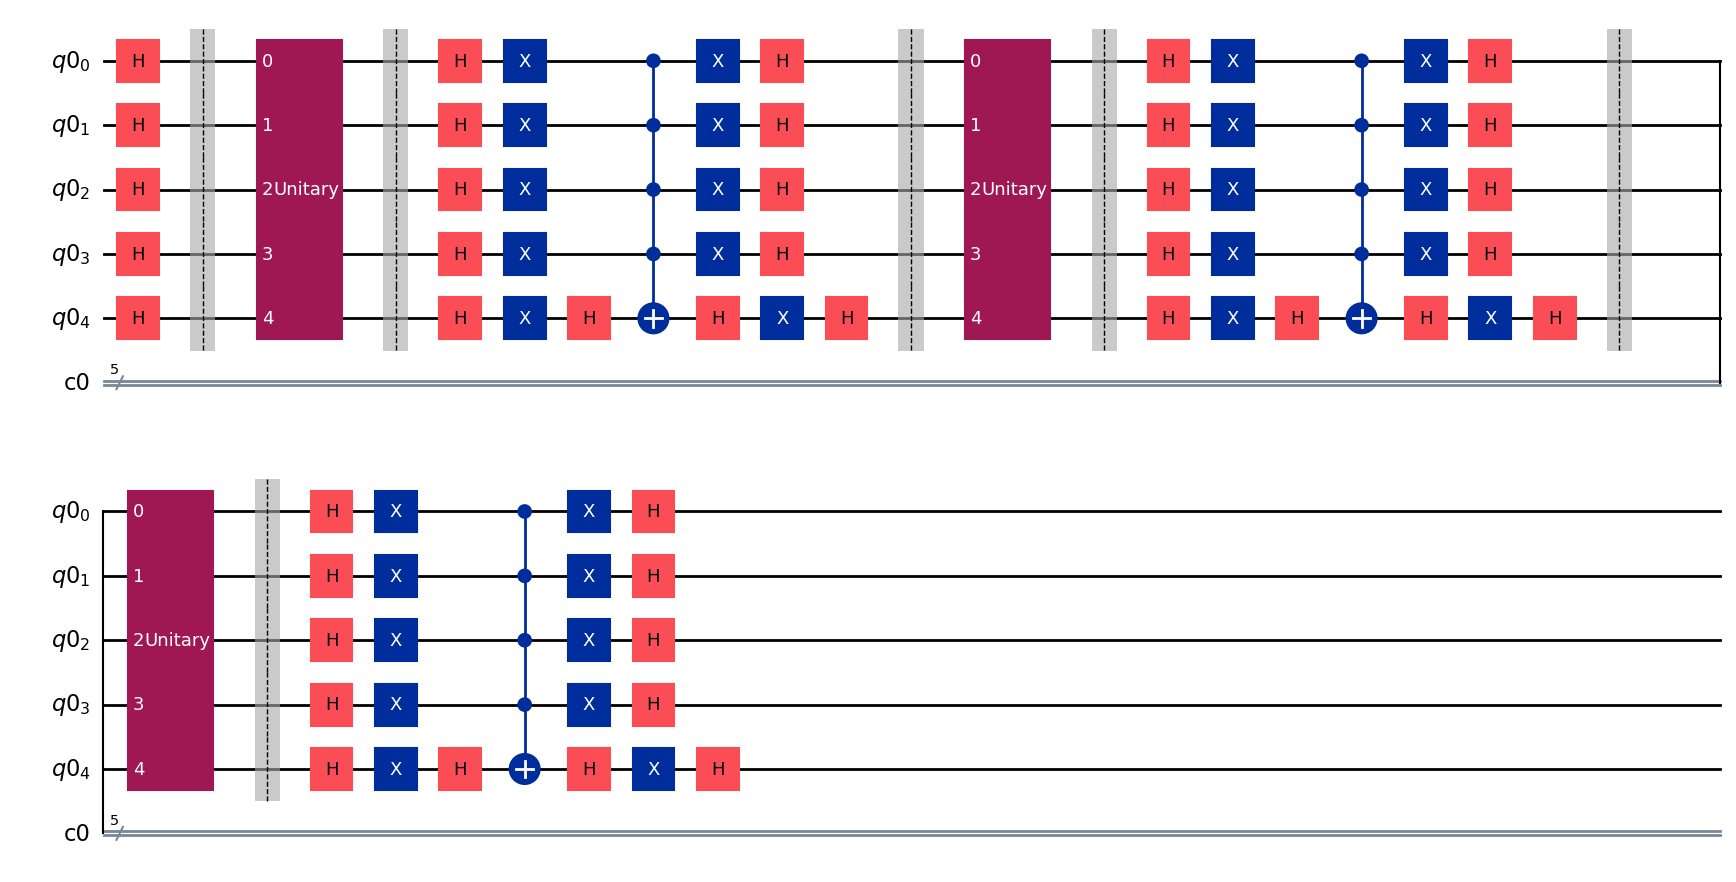

In [5]:
grover_circuit.draw("mpl")

## Compare effect of different values of sigma

Instead of executing the circuit, we check to see the final statevector before measurements.

In [6]:
statevector = Statevector(grover_circuit)

The probability of measuring the $00011$ state gives us a likelihood of success for our search exercise.

In [7]:
print(
    f"Search success probability = {(statevector.probabilities_dict()['00011']) * 100: 4f} %"
)

Search success probability =  89.693654 %


## Perturbation with isotropic error

Let us now look at the effect of adding an isotropic error

In [8]:
statevector_error = Statevector(
    generate_and_add_isotropic_error(statevector.data, sigma=0.9).tolist()
)

In [9]:
print(
    f"Search success probability = {(statevector_error.probabilities_dict()['00011']) * 100: 4f} %"
)

Search success probability =  71.233067 %


We see that this has dropped to $89.7\%$ from $71.2\%$.

## Increased iterations

Now let's check the final probability (after isotropic error) when we run the algorithm with 4 iterations of the oracle + diffusion operator instead of 3.

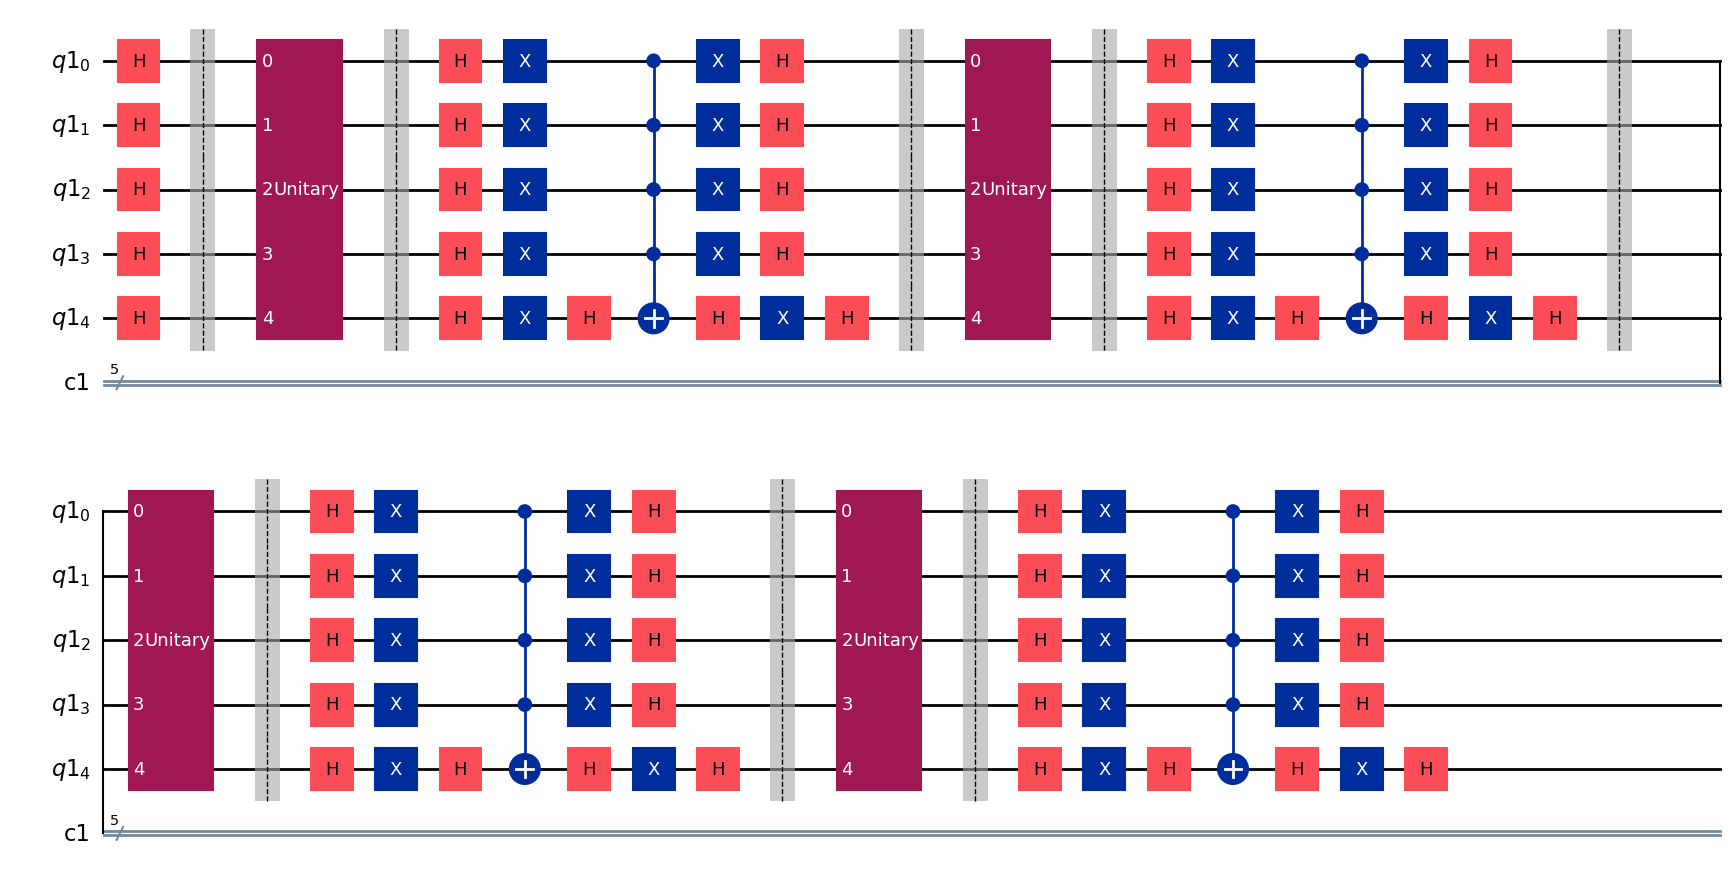

In [10]:
grover_circuit = get_grover_circuit(num_qubits=num_qubits, U_w=U_w, iterations=4)
grover_circuit.draw("mpl")

In [11]:
statevector = Statevector(grover_circuit)

In [12]:
print(
    f"Search success probability = {(statevector.probabilities_dict()['00011']) * 100: 4f} %"
)

Search success probability =  99.918232 %


In [12]:
statevector_error = Statevector(
    generate_and_add_isotropic_error(statevector.data, sigma=0.9).tolist()
)

In [13]:
print(
    f"Search success probability = {(statevector_error.probabilities_dict()['00011']) * 100: 4f} %"
)

Search success probability =  79.353241 %


While we are not able to recover the original $89.7\%$ probability, we are able to bump it up to $79.35\%$ now at the cost of increased algorithmic complexity.

## Effect of error level

By tweaking the `sigma` parameter, we can increase the severity of the isotropic error. In this section, we take a look at how the success probability changes when we increase the error.

In [14]:
def get_success_after_error(sigma):
    statevector_error = Statevector(
        generate_and_add_isotropic_error(statevector.data, sigma=sigma).tolist()
    )
    return statevector_error.probabilities_dict()["00011"] * 100

In [15]:
sigmas = jnp.linspace(0.7, 0.99, 100)

In [16]:
success = Parallel(n_jobs=8)(
    delayed(get_success_after_error)(sigma) for sigma in sigmas
)

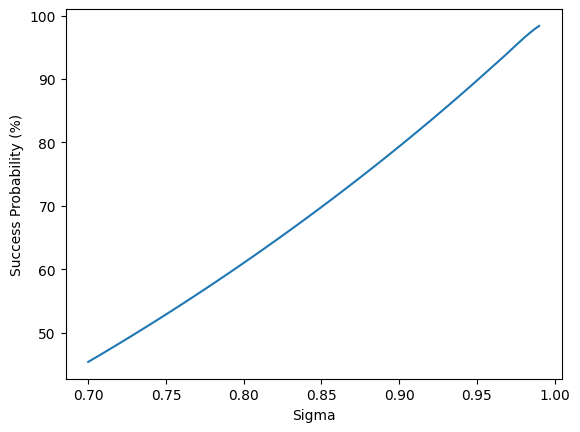

In [17]:
plt.plot(sigmas, success)
plt.xlabel("Sigma")
plt.ylabel("Success Probability (%)")
plt.show()